# Новая механика оплаты услуг на сайте

### A/B-тестирование

В ходе тестирования гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод о целесообразности запуска новой механики оплаты на всех пользователей.

### Входные данные
**groups.csv** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

**group_add.csv** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

**active_studs.csv** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

**checks.csv** - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [90]:
import pandas as pd

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, mannwhitneyu
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

# Вывод всех операций в Jupyter (а не только последней)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Этап. Гипотезы эксперимента

В результате эксперимента для каждой из двух групп подсчитаем 2 базовых метрики эффективности работы сайта:
* Конверсия
* Средний чек

##### Гипотезы
* **H0**: По итогам эксперимента значения базовых метрик изменится
* **H1**: По итогам эксперимента значения базовых метрик изменится

### Этап. Импорт, проверка данных

In [91]:
groups = "csv/groups.csv"
groups_add = "csv/group_add.csv"
active_studs = "csv/active_studs.csv"
checks = "csv/checks.csv"

print("Файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе \n (А – контроль, B – целевая группа)")
df_groups = pd.read_csv(groups, sep=";")
df_groups.head()
df_groups.info()

print("Дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных")
df_groups_add = pd.read_csv(groups_add)
df_groups_add.head()
df_groups_add.info()

print("Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента")
df_active_studs = pd.read_csv(active_studs)
df_active_studs.head()
df_active_studs.info()

print("Файл с информацией об оплатах пользователей в дни проведения эксперимента")
df_checks = pd.read_csv(checks, sep=";")
df_checks.head()
df_checks.info()

Файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе 
 (А – контроль, B – целевая группа)


,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
Дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных


,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента


,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
Файл с информацией об оплатах пользователей в дни проведения эксперимента


,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


### Объединяем таблицы

In [92]:
df = df_groups.append(df_groups_add)
df_groups.shape
df_groups_add.shape
df.shape

C:\Users\OMALAS~1\AppData\Local\Temp/ipykernel_12120/379761011.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_groups.append(df_groups_add)


(74484, 2)

(92, 2)

(74576, 2)

### Оставляем только пользователей, которые заходили на сайт

In [93]:
df = df[df.id.isin(df_active_studs.student_id)]
df.shape

(8341, 2)

### Объединяем 2 таблицы: пользователи - оплата

In [94]:
df = df.merge(df_checks, left_on='id', right_on='student_id', how='left')
# Удаляем лишний столбец (дубликат из правой таблицы)
df = df.drop(columns='student_id')   
df.shape
df

(8341, 3)

,id,grp,rev
0,1627,A,990.0
1,2085,B,NaN
2,2215,B,NaN
3,3391,A,NaN
4,3401,B,NaN
...,...,...,...
8336,5760471,B,NaN
8337,5777081,B,NaN
8338,5870856,A,NaN
8339,5945085,B,NaN


### Выбор метрик и из подсчет

Исходя из имеющихся данных предлагается 3 метрики:
1. Конверсия: отношение покупок к посетителям
2. Средний чек: отношение общей суммы покупок к покупателям
3. Кол-во повторных покупок

In [95]:
# Проверим: есть ли повторные покупки?
df.id.value_counts()

1627       1
3301823    1
3300381    1
3300192    1
3299928    1
          ..
1339665    1
1339662    1
1338134    1
1338133    1
5951797    1
Name: id, Length: 8341, dtype: int64

In [96]:
# Повторных покупок нет - 3-я метрика отметается

##### Конверсия

In [97]:
conv_A = round((df[(df['grp']=='A') & (df.rev.notna())].shape[0] / df[df['grp']=='A'].shape[0]) * 100, 2)
conv_B = round(df[(df['grp']=='B') & (df.rev.notna())].shape[0] / df[df['grp']=='B'].shape[0] * 100, 2)
print(f"Конверсия в группе A: {conv_A}%")
print(f"Конверсия в группе B: {conv_B}%")

Конверсия в группе A: 5.07%
Конверсия в группе B: 4.62%


##### Средний чек

In [98]:
average_order_A = round( (df[(df['grp']=='A') & (df.rev.notna())].rev.sum()) / ( df[(df['grp']=='A') & df.rev.notna()].shape[0]), 0)
average_order_B = round( (df[(df['grp']=='B') & (df.rev.notna())].rev.sum()) / ( df[(df['grp']=='B') & df.rev.notna()].shape[0]), 0)
print(f"Средний чек в группе A: {average_order_A}")
print(f"Средний чек в группе B: {average_order_B}")

Средний чек в группе A: 934.0
Средний чек в группе B: 1258.0


### Определение статистической значимости полученного результата

##### Средний чек

In [99]:
df_rev = df[df.rev.notna()]

<AxesSubplot:xlabel='grp', ylabel='rev'>

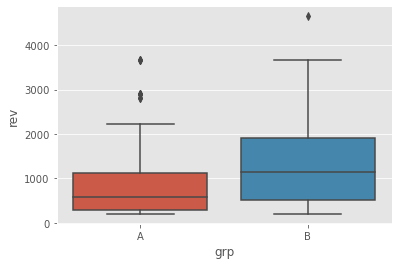

In [100]:
# Построим боксплот
sns.boxplot(data=df_rev, x='grp', y='rev') 

c:\users\omalashenko\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rev', ylabel='Density'>

c:\users\omalashenko\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rev', ylabel='Density'>

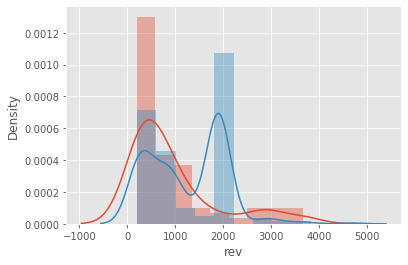

In [101]:
# Дисперсия тестовой выборки - больше

# Построим гистограммы  по каждой группе
sns.distplot(df_rev[df_rev.grp == 'A'].rev)
sns.distplot(df_rev[df_rev.grp == 'B'].rev)

In [102]:
# Тест на нормальное распределение ОБЕ выборки
# Нулевая гипотеза - нормальное распределение
k2, p = stats.normaltest(df_rev[df_rev.grp == 'A'].rev)
p
k2, p = stats.normaltest(df_rev[df_rev.grp == 'B'].rev)
p

2.5316868804220266e-07

0.033445723194625424

In [103]:
# Вывод: обе выборки распределены не нормально

In [104]:
# Сравним ДВЕ выборки непараметричесим методом - критериий mann-whitney
mannwhitneyu(df_rev[df_rev.grp == 'A'].rev, df_rev[df_rev.grp == 'B'].rev)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

In [105]:
# Вывод: средние двух выборок значимо различаются

##### Конверсия

In [106]:
# Добавим в df еще одно поле - "rev_flag"  0-покупки не было, 1-была
df['rev_flag'] = df['rev'].apply(lambda x: 1 if x > 0 else 0)
df.head()

,id,grp,rev,rev_flag
0,1627,A,990.0,1
1,2085,B,NaN,0
2,2215,B,NaN,0
3,3391,A,NaN,0
4,3401,B,NaN,0


In [107]:
df

,id,grp,rev,rev_flag
0,1627,A,990.0,1
1,2085,B,NaN,0
2,2215,B,NaN,0
3,3391,A,NaN,0
4,3401,B,NaN,0
...,...,...,...,...
8336,5760471,B,NaN,0
8337,5777081,B,NaN,0
8338,5870856,A,NaN,0
8339,5945085,B,NaN,0


###### Подсчет статистической значимости с помощью критерия ХИ-квадрат

In [108]:
from scipy.stats import chi2_contingency

Нулевая гипотеза критерия ( H0 ) утверждает, что нет никакой связи между переменными. 

Альтернативная гипотеза - между ними существует значительная связь.

Т.е. в нашем случае, альтернативная гипотеза утверждает, что существует связь между фактом покупки (конверсия) и исходной группой.

In [109]:
df_test = pd.crosstab(df['grp'], df['rev_flag']).reset_index()
df_test = df_test.set_index('grp')
df_test

rev_flag,0,1
grp,,
A,1460,78
B,6489,314


In [110]:
stat, p, dof, expected = chi2_contingency(df_test)
print(f"Уровень значимости p - {p}")

Уровень значимости p - 0.48625240457231045


**Вывод**: Уровень значимости существенно выше 0,05, поэтому - мы отвергаем НЕнулевую гипотезу.

###### Дополнительно: подсчет статистической значимости с помощью бутстрапа

In [111]:
# С помощью бутстрапа выясним: существует ли статистическая значимость полученной разницы в конверсиях между выборками.
# Считаея среднее поля "rev_flag" - фактически мы считаем конверсию

In [112]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    # Чтобы уровнять размер контрольной и тестовой выборок
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []   # Сюда будем складывать оценки по Бутстрапу
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем эту статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    # Считаем доверительный интервал
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    # Считаем P-value по нормальному распределению
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

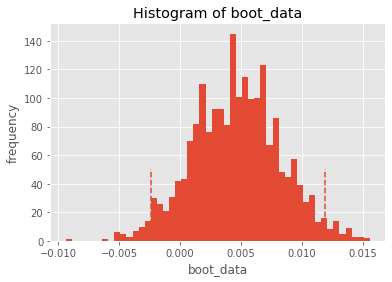

In [113]:
# В результате хранится разница двух распределений, ДИ и pvalue
booted_data = get_bootstrap(df[df.grp == 'A'].rev_flag, df[df.grp == 'B'].rev_flag, boot_it = 2000) 

In [114]:
# P-value
booted_data["p_value"]

0.1945856191816333

In [115]:
# Доверительные интервал
booted_data["ci"]

,0
0.025,-0.002352
0.975,0.011910


In [116]:
# Вывод: полученная разница в конверсии - статистичеки не значима

### Итоговые выводы

По результатам AB-теста выявлено **статистически значимое** увеличение вкличины среднего чека с **934.0** до **1258.0**

Вычисленое снижение конверсии с 5.07% до 4.62% - **статистически не значимо**.

**Вывод: по итогам экспериманте принимаем НЕнулевую гипотезу в отошении метрики "Средний чек" и принимаем решение, что запускать новую механику на всех пользователей целесообразно.**